## Demsonstration of 1-D and 1-D time dilitated convolutions

**Goal:** in this notebook you will use 1D causal convolution to predict timeseries. You learn how 1D convolutions with causal padding work and see that dilated causal convolution are able capture long-range dependencies.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it. There are no marked excercises, but please feel free to play around with the code.

**Dataset:** We will use an articfical dataset with some long-range dependencies. We generate 1000 timeseries with the length of 128 timesteps that all follow the same pattern: a fast changing sine wave where the amplitude is modulated by an other sine wave with lower frequency. To make it a bit more challenging, we add some noise at each timestep of the waves. Our goal is to first predict the next 10 timesteps and the we want to predict for even longer timesteps in the future.

**Content:**
* articfical dataset with some long-range dependencies
* visualize a samples timeseries
* use keras to train a CNN with 1D causal convolutions
* predict the next 10 timesteps of the timeseries and comple the MSE loss with a simple baseline model
* predict the next 100 timesteps of the timeseries and see that you need to stack many 1D causal convolution to capture long range long-range dependencies
* use keras to train a CNN with 1D dilitated causal convolutions (which are abe to deal with long-range dependencies)
* predict the next 100 timesteps of the timeseries and see that with 1D dilitated causal convolutions, we are able to learn longer dependencies

[open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/nb_ch02_04.ipynb)

#### Install correct TF version (colab only)

In [1]:
# Execute this cell to be sure to have a compatible TF (2.0) version. 
# If you are bold you can skip this cell. 
try: #If running in colab 
  import google.colab
  !pip install tensorflow==2.0.0
except:
  print('Not running in colab')

#### Imports

In the next cell, we load all the required libraries and functions

In [2]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [3]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  True


In [4]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Lambda, Convolution1D
from tensorflow.keras.utils import to_categorical 


### Understanding Causal Padding

Let's look at a very simple example to show how causal convolution work.
We use a single 1dimensional kernel of size 2 with the weights 1 and 2, our input sequence ist  (10,20,30). If we do a causal convolution the result will be (20,50,80).
The padding makes sure that the output sequence has the same length as the input sequence, by adding zeros where needed. (just linke when you do 2D Convolutions).  
So in this example we need to add 1 zero in the beginnig of the sequence to get the outputlength of 3.  

0$\cdot$ 1+10$\cdot$2=20  
10$\cdot$1+20$\cdot$2=50  
20$\cdot$1+30$\cdot$2=80  
resulting in (20, 50, 80)

![](https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/ch02_30.png)

Let's verify this result with a keras model.  
We define a simple keras model with a 1D Convolution and a kernelsize of 2 and use causal convolution with padding.  
The input sequence has a length of 3 and one feature so the input shape is: (batchsize, nr_of_timesteps, input_features)

In [5]:
model = Sequential()
model.add(Convolution1D(filters=1, 
                 kernel_size=2, 
                 padding='causal', 
                 dilation_rate=1,
                 use_bias=False,
                 batch_input_shape=(None,3, 1)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 1)              2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.set_weights([np.asarray([[[1]],[[2]]])])
print(model.get_weights())

[array([[[1.]],

       [[2.]]], dtype=float32)]


In [7]:
x_in=np.array([10,20,30])
x_in=x_in.reshape(1,3,1)
print("input")
print(x_in)
print("output")
print(model.predict(x_in))

input
[[[10]
  [20]
  [30]]]
output
[[[20.]
  [50.]
  [80.]]]


### An other simple toy example

#### Creation of the training data

We produce training data with two different time scales and a bit of noise. This produces 1000 curves which all follow the same pattern: a fast changing sine wave where the amplitude is modulated by a sine wave with lower frequency. To make it a bit more challenging, we add some noise at each timestep of the waves. All of the 1000 waves have the same pattern, however, the starting point is randomly shifted in time. One such example is shown the plot below. The first 128 data points are used as an input to the model (shown as a line). The model should predict the following 10 data points (shown as points). Note that the future data does not follow a smooth curve, but instead is ragged because of the random noise present in the data. 

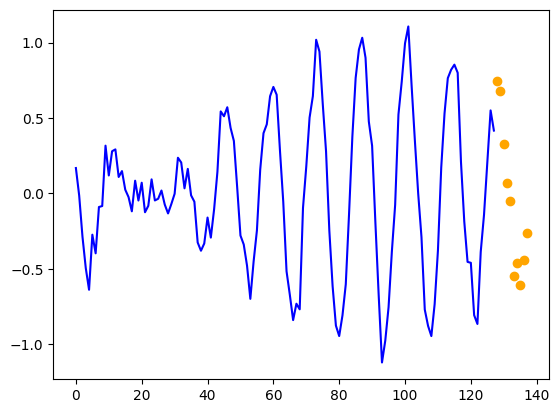

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [8]:
np.random.seed(1) # Fixing the seed, so that data is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1): # We create 1000 data-points
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(1):
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

In [9]:
X.shape, Y.shape

((1000, 128, 1), (1000, 10, 1))

### The model with time dilated convolutions

Let’s build a first model using the causal convolutions. Our input tensor  has a of shape (batch size, 128, 1). Note that we didn’t specify the sequence length (batch_input_shape=(None, None, 1)). We did that for a reason. In the training, we use a sequence length of 128, but you can use a different sequence length in the prediction.

The input is passed through the first 1-dimensional convolutional layer. Since we use a causal zero padding as indicated in figure 2.30 and in the cells above, the sequence length of the tensor stays the same in the course of going through the neural network. The number of input freatures (channels) is 1 (one signal per time step) and it’s is widdend to 32 by applying 32 kernels in the first convolution. We stack 4, 1-dimensional convolutional layer with a kernelsize of ks=5 and we use the first 800 sequences for training and the last 200 as our validation.

Before going to the output layer, we go back from 32 to one value per timestep using a dense layer. The output is now (batch size, 128, 1). We only want to predict 10 data points in the future, so we strip all but the last 10 data points. We do this by applying the slice function. As loss function we use the mean squared error (MSE), because our aim is to predict Y-values that are as close as possible to the observed values corresponding to a low MSE. You will learn more on the MSE in chapter 3 and 4. Don’t bother about the learning process now.   


In [10]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]
  
model1 = Sequential()
ks = 5
model1.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', batch_input_shape=(None, None, 1)))
model1.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model1.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model1.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model1.add(Dense(1))
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model1.summary()
model1.compile(optimizer='adam', loss='mean_squared_error')


history1 = model1.fit(X[0:800], Y[0:800],
                    epochs=100,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
__________________________________________________

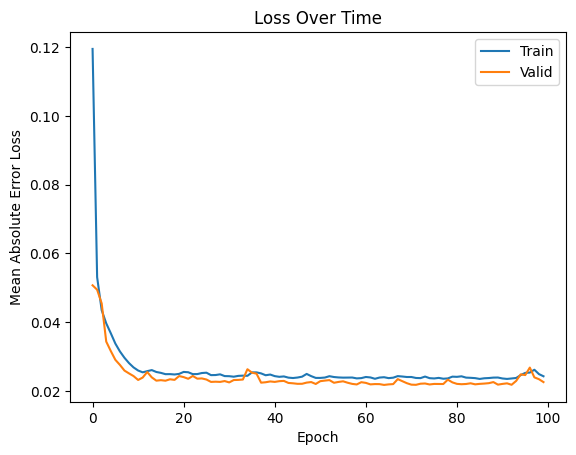

In [11]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

During training, the model loss goes down on the train and the validation data indicating that we successfully trained the model. Here we use the mean square error (MSE) as loss, which reaches after around 100 epochs of training the value of around 0.02.

Since we work with simulated data, we can produce as much new data as we like. We can also switch off the noise and check how well the model can extract the real underlying pattern in the data.  
If we do so, and simulate 1000 new sequeces without noise, and predict the next 10 timesteps, we get an MSE of around 0.0067. A good baseline benchmark in the analysis of time series is to just take the last value for the new prediction. This benchmark yields an MSE of around 0.0626 in our case. If we compare the model to baseline we see the model has learned something, because we have a lower MSE.

In [12]:
# Testing on new data
X,Y = gen_data(noise=0)
res = model1.predict(X) 
print('Shapes X {} Y{} res{}'.format(X.shape, Y.shape, res.shape))
print('MSE for complete look-ahead ', np.average((res[:,:,0] - Y[:,:,0])**2)) 
print('MSE for one step look-ahead ', np.average((res[:,0,0] - Y[:,0,0])**2)) 
print('MSE baseline (same as last)', np.average((X[:,-1,0] - Y[:,0,0])**2)) 
#[np.average((res[:,i,0] - Y[:,i,0])**2) for i in range(10)]

Shapes X (1000, 128, 1) Y(1000, 10, 1) res(1000, 10, 1)
MSE for complete look-ahead  0.007549886905472531
MSE for one step look-ahead  0.011955214400814896
MSE baseline (same as last) 0.06147579415035294


Let’s  look at an example where we predict a longer sequence. We start with a sequence of 128 time steps. This is the first (left) curve in the plot below ranging from 0 to 128. Then we predict the next 10 time steps and use those as a new starting points. We define a function to repeat this procedure 10 times and get a prediction looking 100 time steps ahead. This is the second brighter line (right) in the plot below. 

In [13]:
x_test,y_test = gen_data(size=1,noise=0.0)
model1.predict(x_test).reshape(-1),y_test.reshape(-1)

(array([ 0.92308974,  0.90207654,  0.70582265,  0.37736496, -0.01334495,
        -0.38446322, -0.6595567 , -0.7834973 , -0.7336097 , -0.5237993 ],
       dtype=float32),
 array([ 0.85230934,  0.88453287,  0.73468149,  0.43794298,  0.05913728,
        -0.32152731, -0.6255856 , -0.7926458 , -0.7924877 , -0.63048301]))

In [14]:
# Prediction one after another
def predict_sequence(input_sequence, model, pred_steps):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps * look_ahead,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-look_ahead:,0]
        pred_sequence[0,(i * look_ahead) : ((i+1) * look_ahead),0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,look_ahead,1)], axis=1)

    return pred_sequence

(-1.0, 1.0)

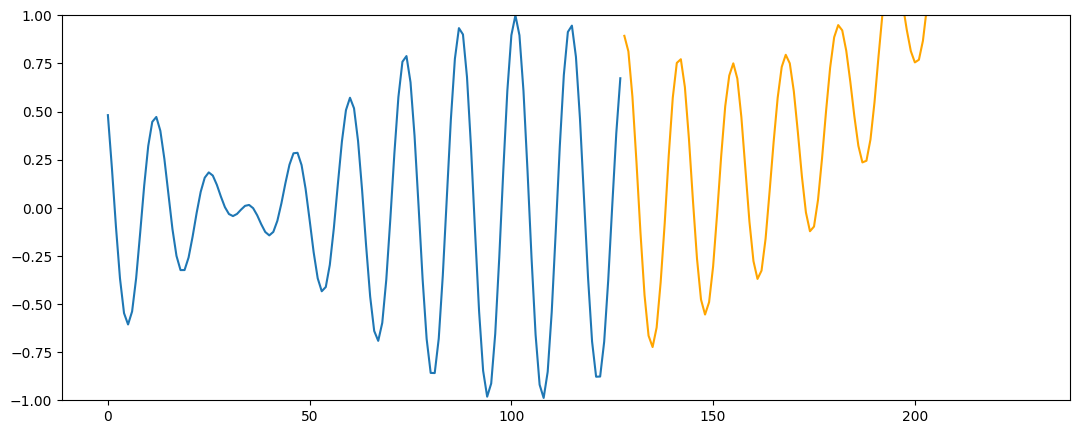

In [15]:
plt.figure(num=None, figsize=(13,5))
pred_steps = 10
x_test,y_test = gen_data(size=1,noise=0.0)
preds = predict_sequence(x_test, model1, pred_steps)
plt.plot(range(0,len(x_test[0])),x_test[0,:,0])
plt.plot(range(len(x_test[0]),len(x_test[0])+len(preds[0])),preds[0,:,0],color='orange')
plt.ylim((-1,1))

Looking at the predictions in the figure from above, we see that the neural network learns the fast moving pattern in the data, but isn’t capable of predicting the slower wobbling of the signal, which encompasses longer time scales and the signal breaks away after some time. If we look at the architecture of the network, we have 4 convolutional layers which each have a kernel of size 5. A kernel of size 5 allows us to look back 4 steps in time. So the 4 convolutional layers can look back 16 time steps, which is not far enough to pick-up the slow-moving pattern.

We need a network thatcan look back over longer times. 


## Background
With a normal causal 1D convolution of length 2 you can look back one time step. A kernel of size 2 allows to look back 1 step in time. So the 4 convolutional layers can look back 4 time steps.

![](https://i.stack.imgur.com/MhYzp.png)

You can stack k causal 1D convolutions with kernel size 2 which allows you to look back k timesteps. Increasing the kernel size helps a bit. If you need to look back many timesteps you need to stack a lot of causal 1D convolutions which makes it hard to fit the model. Often the output should depend on more distance events. 

However, for the above data, we need a network, which can look back longer times. A solution for that are dilated convolutions. These have been popularized in Google’s wavenet paper, where they model the long-reaching correlations in the human speech and allow to produce unprecedented realistic text to speech samples. The key components of the wavenet are dilated convolutions shown in the figure below. These are stacks of simple 1D convolutions, where the filters in deeper layers do not take into account all neighboring neurons but skip some neurons by making step sizes larger than 1. The step size is called dilation factor d. In the figure below you see a dilated causal 1D convolution with d=2 in the first hidden layer, d=4 in the second hidden layer, and d=8 in the third hidden layer. With this trick a neuron in the last layer has a receptive field in the past of 15 time steps instead of 4 time steps when working with the same filter size and depth, but without applying dilations (see figure above). You can get even longer histories with this dilation trick if you work with larger filters and stack more layers. Some studies on benchmark sequence data showed that the memory of this easy 1D convolution NN can in many examples even outperform the more complicated LSTM or GRU networks. 


### Dilation Trick
The trick is to use dilated convolutions shown in the figure below. These are simple convolutions, which look back several time steps. While a normal convolution of length 4 looks back at the times 0,1,2,3, a dilated convolution with a dilation factor 2 can look back at the times 0,2,4, 8. By stacking many of those, you can get back a considerable amount.  In our case we can go back 4^4 = 256 time steps.


![](https://i.stack.imgur.com/20xRe.png)

To use time-dilated convolutions, simply add the dilation rate `dilation_rate=...` to the `Convolution1D` layer. We use the same model as above but just replaced a bit code marked with (#<------ Just replaced this block)

In [16]:
X,Y = gen_data(noise=0)

modeldil = Sequential()
#<------ Just replaced this block
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=1, 
                           batch_input_shape=(None, None, 1)))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=2))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=4))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=8))
#<------ Just replaced this block

modeldil.add(Dense(1))
modeldil.add(Lambda(slice, arguments={'slice_length':look_ahead}))

modeldil.summary()

modeldil.compile(optimizer='adam',loss='mean_squared_error')

histdil = modeldil.fit(X[0:800], Y[0:800],
                    epochs=200,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]), verbose=0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           33        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
__________________________________________________

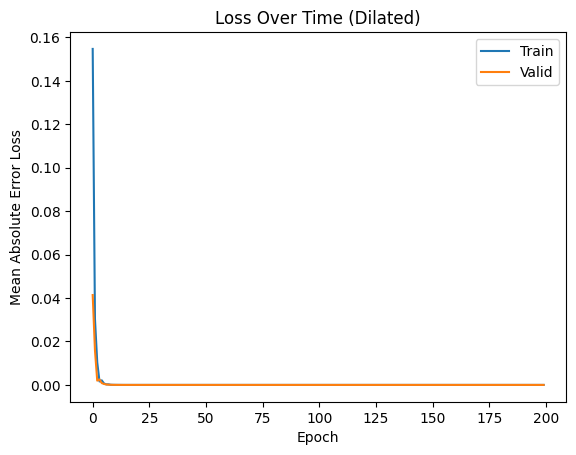

In [17]:
plt.plot(histdil.history['loss'])
plt.plot(histdil.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time (Dilated)')
plt.legend(['Train','Valid'])

In [18]:
# Testing
X,Y = gen_data()
res = modeldil.predict(X) 
print('MSE for one step look-ahead ', np.average((res[:,0,0] - Y[:,0,0])**2)) #One step look-ahead prediction
print('MSE baseline (same as last)', np.average((X[:,-1,0] - Y[:,0,0])**2)) 

MSE for one step look-ahead  0.012959228393635683
MSE baseline (same as last) 0.08270541455379668


(-1.0, 1.0)

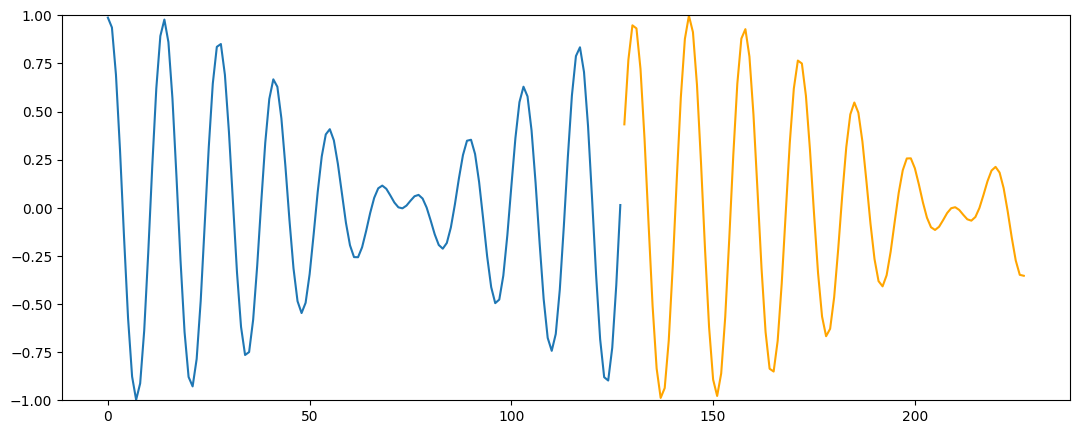

In [19]:
plt.figure(num=None, figsize=(13,5))
pred_steps = 10
x_test,y_test = gen_data(size=1,noise=0.0)
preds = predict_sequence(x_test, modeldil, pred_steps)
plt.plot(range(0,len(x_test[0])),x_test[0,:,0])
plt.plot(range(len(x_test[0]),len(x_test[0])+len(preds[0])),preds[0,:,0],color='orange')
plt.ylim((-1,1))

The learning of the model is similar to the non-dilated example (with a similar MSE and speed of learning), but look at figure of the many steps prediction and see what happened: The network now also picked up the long-range time dependencies. Now we can accurately predict for much more longer steps than only 10. It looks too good to be true.

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  
*Excecise (optional): Go play around with the code (try to remove some layers or shorten the dilation factor)*